#Setup

In [94]:
!apt-get install ffmpeg freeglut3-dev xvfb  # For visualization
!pip install "stable-baselines3[extra]>=2.0.0a4"

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
The following additional packages will be installed:
  freeglut3 libegl-dev libfontenc1 libgl-dev libgl1-mesa-dev libgles-dev libgles1 libglu1-mesa
  libglu1-mesa-dev libglvnd-core-dev libglvnd-dev libglx-dev libice-dev libopengl-dev libsm-dev
  libxfont2 libxkbfile1 libxt-dev x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common
Suggested packages:
  libice-doc libsm-doc libxt-doc
The following NEW packages will be installed:
  freeglut3 freeglut3-dev libegl-dev libfontenc1 libgl-dev libgl1-mesa-dev libgles-dev libgles1
  libglu1-mesa libglu1-mesa-dev libglvnd-core-dev libglvnd-dev libglx-dev libice-dev libopengl-dev
  libsm-dev libxfont2 libxkbfile1 libxt-dev x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common xvfb
0 upgraded, 25 newly installed, 0 to remove and 23 not upgraded.
Need t

In [95]:
import gymnasium as gym
import numpy as np
from gymnasium import spaces
from stable_baselines3.common.env_checker import check_env


#Environment

In [96]:
def seasonal_duck_curve(hour, season, noise_scale=0.03):
    """ Computes electricity demand based on seasonal duck curve """
    A = 400
    seasonal_params = {
        1: (100, 7, 80, 12, 120, 14, 250, 18, 30, 4),  # Summer
        2: (180, 6, 40, 12, 80, 14, 220, 17, 60, 4),  # Winter
        3: (130, 7, 90, 12, 100, 14, 180, 18, 40, 4)  # Spring/Autumn
    }
    B, t_morning, C, t_dip, D, mu_dip, E, t_evening, F, t_early = seasonal_params[season]
    demand = A + B / (1 + np.exp(-1 * (hour - t_morning))) - C / (1 + np.exp(-1 * (hour - t_dip))) - D * np.exp(-((hour - mu_dip)**2) / 4) + E / (1 + np.exp(-1 * (hour - t_evening)))
    return demand * random.uniform(0.9, 1.1)

def electricity_price_function(hour, season, demand, noise_scale=0.03):
    """ Computes electricity price based on seasonal demand """
    season_params = {
        1: (30, 15, 10),  # Summer
        2: (28, 14, 9),   # Winter
        3: (25, 12, 8)    # Spring/Autumn
    }
    A_q, B_q, C_q = season_params[season]
    base_price = A_q + B_q * np.cos(2 * np.pi * hour / 24) + C_q * np.cos(4 * np.pi * hour / 24)
    return max(base_price * random.uniform(0.9, 1.1), 0)


In [97]:
import gymnasium as gym
import numpy as np
from gymnasium import spaces
import random

class ElectricityMarketEnv(gym.Env):
    """
    Custom Gym environment for an electricity market with battery storage.
    The agent decides when to charge/discharge to maximize profit.
    """
    def __init__(self, max_timesteps=365, degradation_rate=0.99):
        super(ElectricityMarketEnv, self).__init__()
        self.timestep = 0
        self.max_timesteps = max_timesteps
        self.season = self.get_season_from_timestep(0)  # Set initial season based on real months
        self.episode_count = 0  # Track training episodes
        self.degradation_rate = degradation_rate  # Battery degradation factor

        # Battery parameters
        self.initial_battery_capacity = 100  # Initial max storage capacity
        self.battery_capacity = self.initial_battery_capacity  # Maximum storage capacity
        self.battery_soc = 50  # Initial state of charge (SoC)
        self.efficiency = 0.95  # Charging/discharging efficiency

        # Electricity market parameters
        self.base_min_price, self.base_max_price = self._calculate_price_bounds()
        self.base_min_demand, self.base_max_demand = self._calculate_demand_bounds()

        self.min_price, self.max_price = self.base_min_price * 0.9, self.base_max_price * 1.1
        self.min_demand, self.max_demand = self.base_min_demand * 0.9, self.base_max_demand * 1.1


        # Action space: Charge (+) or discharge (-) within battery capacity
        self.action_space = spaces.Box(low=-self.battery_capacity, high=self.battery_capacity, shape=(1,), dtype=np.float32)

        # Observation space: [Battery SoC, Battery Capacity, Electricity Price, Demand, Hour, Season]
        self.observation_space = spaces.Box(
            low=np.array([0, 50, self.min_price, self.min_demand, 0, 1], dtype=np.float32),
            high=np.array([self.initial_battery_capacity, self.initial_battery_capacity, self.max_price, self.max_demand, 23, 3], dtype=np.float32),
            dtype=np.float32
        )

        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.battery_capacity = self.initial_battery_capacity  # Reset battery capacity
        self.timestep = 0
        self.battery_soc = 50  # Reset battery SoC
        self.season = self.get_season_from_timestep(self.timestep)  # Set season dynamically
        self.episode_count += 1  # Track episode count
        return self._get_state(), {}

    def step(self, action):
        """
        Executes one step in the environment.
        Action: Charge (>0) or discharge (<0) electricity.
        """
        self.timestep += 1
        self.season = self.get_season_from_timestep(self.timestep)
        done = self.timestep >= self.max_timesteps or self.battery_soc <= 0

        self.battery_capacity *= self.degradation_rate
        self.battery_capacity = max(self.battery_capacity, 50)  # Minimum capacity limit

        # Get new price and demand based on season
        hour = self.timestep % 24
        demand = seasonal_duck_curve(hour, self.season)
        price = electricity_price_function(hour, self.season, demand)

        # Clip action to valid range (-battery_capacity, +battery_capacity)
        action = np.clip(action[0], -self.battery_capacity, self.battery_capacity)

        # Charge/discharge the battery
        if action > 0:  # Charging (cost money)
            charge_amount = min(action, self.battery_capacity - self.battery_soc)
            cost = charge_amount * price / self.efficiency
            self.battery_soc += charge_amount * self.efficiency
            reward = -cost  # Negative reward for spending money
            #print(f"Step {self.timestep}, Season: {self.get_season_name(self.season)}: Charging {charge_amount:.2f} units at price {price:.2f}. Cost: {cost:.2f}. SoC: {self.battery_soc:.2f}.")
        else:  # Discharging (sell to market)
            discharge_amount = min(-action, self.battery_soc, demand)
            revenue = discharge_amount * price * self.efficiency
            self.battery_soc -= discharge_amount / self.efficiency
            reward = revenue  # Positive reward for selling
            #print(f"Step {self.timestep}, Season: {self.get_season_name(self.season)}: Discharging {discharge_amount:.2f} units at price {price:.2f}. Revenue: {revenue:.2f}. SoC: {self.battery_soc:.2f}.")

        next_state = np.array([self.battery_soc, self.battery_capacity, price, demand, hour, self.season], dtype=np.float32)
        return next_state, reward, done, False, {}

    def _get_state(self):
        """ Returns the current state: [SoC, Price, Demand, Hour, Season] """
        hour = self.timestep % 24
        demand = seasonal_duck_curve(hour, self.season)
        price = electricity_price_function(hour, self.season, demand)
        #print(f"State - SoC: {self.battery_soc:.2f}, Price: {price:.2f}, Demand: {demand:.2f}, Hour: {hour}, Season: {self.season}.")
        return np.array([self.battery_soc, self.battery_capacity, price, demand, hour, self.season], dtype=np.float32)



    def get_season_from_timestep(self, timestep):
        """ Determines season based on day of the year """
        month = (timestep // 30) % 12  # Approximate month from timestep
        if month in [11, 0, 1]:
            return 2  # Winter
        elif month in [5, 6, 7]:
            return 1  # Summer
        else:
            return 3  # Spring/Autumn

    def get_season_name(self, season):
        return {1: "Summer", 2: "Winter", 3: "Spring/Autumn"}.get(season, "Unknown")


    def evaluate_agent(self, agent, num_episodes=3):
        """ Evaluates the agent over multiple episodes and prints performance metrics per season. """
        total_rewards = []
        season_rewards = {1: [], 2: [], 3: []}

        for ep in range(num_episodes):
            state, _ = self.reset()
            done = False
            episode_reward = 0
            seasonal_reward = {1: 0, 2: 0, 3: 0}

            while not done:
                action, _ = agent.predict(state)
                state, reward, done, _, _ = self.step(action)
                episode_reward += reward
                seasonal_reward[self.season] += reward

            total_rewards.append(episode_reward)
            for season in seasonal_reward:
                season_rewards[season].append(seasonal_reward[season])


        avg_reward = np.mean(total_rewards)
        avg_seasonal_rewards = {season: np.mean(rewards) if rewards else 0 for season, rewards in season_rewards.items()}

        print(f"\nEvaluation Results:")
        print(f"Average Reward over {num_episodes} episodes: {avg_reward:.2f}")
        print(f"Seasonal Performance:")
        for season, avg in avg_seasonal_rewards.items():
            print(f"  {self.get_season_name(season)}: {avg:.2f}")

        return avg_reward, avg_seasonal_rewards

    def _calculate_price_bounds(self):
        """ Determine min/max price dynamically based on electricity_price_function """
        min_price = float('inf')
        max_price = float('-inf')
        for season in [1, 2, 3]:
            for hour in range(24):
                demand = seasonal_duck_curve(hour, season)
                price = electricity_price_function(hour, season, demand)
                min_price = min(min_price, price)
                max_price = max(max_price, price)
        return min_price, max_price

    def _calculate_demand_bounds(self):
        """ Determine min/max demand dynamically based on seasonal_duck_curve """
        min_demand = float('inf')
        max_demand = float('-inf')
        for season in [1, 2, 3]:
            for hour in range(24):
                demand = seasonal_duck_curve(hour, season)
                min_demand = min(min_demand, demand)
                max_demand = max(max_demand, demand)
        return min_demand, max_demand



In [98]:
env = ElectricityMarketEnv()
obs, _ = env.reset()



#Evaluation Functions


In [99]:
from stable_baselines3.common.evaluation import evaluate_policy


In [100]:
%pip install tensorboard
%load_ext tensorboard


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [101]:
import time
import numpy as np
import tensorflow as tf
from stable_baselines3.common.callbacks import BaseCallback

class RLComparisonCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(RLComparisonCallback, self).__init__(verbose)
        self.start_time = time.time()

    def _on_training_start(self) -> None:
        self.episode_rewards = []
        self.episode_lengths = []
        self.total_timesteps = 0

    def _on_step(self) -> bool:
        if self.locals.get("dones") is not None:
            for done, reward, info in zip(self.locals["dones"], self.locals["rewards"], self.locals["infos"]):
                if done:
                    episode_reward = info.get("episode", {}).get("r", reward)
                    episode_length = info.get("episode", {}).get("l", 0)

                    self.episode_rewards.append(episode_reward)
                    self.episode_lengths.append(episode_length)
                    self.total_timesteps += episode_length

                    # Logging metrics after each episode using log scale
                    avg_reward = np.mean(self.episode_rewards[-100:])
                    cum_reward = np.sum(self.episode_rewards)
                    discounted_reward = np.sum([r * (0.99 ** i) for i, r in enumerate(self.episode_rewards)])
                    convergence_rate = np.std(self.episode_rewards[-100:])
                    sample_efficiency = cum_reward / max(1, self.total_timesteps)
                    stability = np.std(self.episode_rewards)
                    policy_entropy = info.get('entropy', 0)
                    time_complexity = time.time() - self.start_time
                    space_complexity = self.model.policy.parameters_to_vector().nbytes

                    self.logger.record("custom/average_reward", avg_reward)
                    self.logger.record("custom/cumulative_reward", cum_reward)
                    self.logger.record("custom/discounted_reward", discounted_reward)
                    self.logger.record("custom/convergence_rate", convergence_rate)
                    self.logger.record("custom/sample_efficiency", sample_efficiency)
                    self.logger.record("custom/stability", stability)
                    self.logger.record("custom/policy_entropy", policy_entropy)
                    self.logger.record("custom/time_complexity", time_complexity)
                    self.logger.record("custom/space_complexity", space_complexity)

        return True


#Lets start with training

In [102]:
SEEDS = [22, 68, 34, 90, 45]
steps = 1000000

In [41]:
from stable_baselines3 import PPO, A2C, SAC, TD3, DDPG

In [104]:
from stable_baselines3.common.callbacks import CheckpointCallback, CallbackList

#PPO

In [105]:

model_type = "PPO"
for seed in SEEDS:
  env.reset(seed=seed)

  checkpoint_callback = CheckpointCallback(
      save_freq=200000,  # Save every 100,000 steps
      save_path='./models/',  # Directory to save the model
      name_prefix=f"{model_type}_{seed}_{steps}"  # Prefix for the saved model files
  )
  ppo_callback = CallbackList([RLComparisonCallback(), checkpoint_callback])

  ppo_model = PPO("MlpPolicy", env, verbose=0, tensorboard_log="./tensorboard/",  seed=seed).learn(steps, callback=ppo_callback, tb_log_name=f"{model_type}_{seed}_{steps}")
  ppo_model.save(f"./models/{model_type}_{seed}_{steps}")

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [ ]:
env.evaluate_agent(ppo_model, num_episodes=365)

#Transfer Learning

In [13]:
!pip install stable-baselines3
!pip install rl-zoo3


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.3/77.3 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 469.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.1/91.1 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.8/92.8 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 4.4 MB/s eta 0:00:00


#Using pretrained weights

In [14]:
from stable_baselines3 import PPO
import gym
from huggingface_sb3 import load_from_hub

checkpoint = load_from_hub(
	repo_id="sb3/ppo-BipedalWalker-v3",
	filename="ppo-BipedalWalker-v3.zip",
)
# Load the pre-trained A2C model from Bipedal Walker
pretrained_model = PPO.load(checkpoint)
# Initialize the new environment
new_env = ElectricityMarketEnv()

new_model = PPO("MlpPolicy", new_env, verbose=0)
new_model.policy.load_state_dict(pretrained_model.policy.state_dict())
new_model.learn(total_timesteps=50_000)

# Evaluate the model after fine-tuning
env.evaluate_agent(new_model, num_episodes=365)

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/save_util.py:167: UserWarning: Could not deserialize object learning_rate. Consider using `custom_objects` argument to replace this object.
Exception: code expected at least 16 arguments, got 15
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/save_util.py:167: UserWarning: Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
Exception: code expected at least 16 arguments, got 15
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/save_util.py:167: UserWarning: Could not deserialize object clip_range. Consider using `custom_objects` argument to replace this object.
Exception: code expected at least 16 arguments, got 15
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:95: UserWarning: You loaded a model that was trained using OpenAI Gym. We strongly recom

RuntimeError: Error(s) in loading state_dict for ActorCriticPolicy:
	size mismatch for log_std: copying a param with shape torch.Size([4]) from checkpoint, the shape in current model is torch.Size([1]).
	size mismatch for mlp_extractor.policy_net.0.weight: copying a param with shape torch.Size([64, 24]) from checkpoint, the shape in current model is torch.Size([64, 6]).
	size mismatch for mlp_extractor.value_net.0.weight: copying a param with shape torch.Size([64, 24]) from checkpoint, the shape in current model is torch.Size([64, 6]).
	size mismatch for action_net.weight: copying a param with shape torch.Size([4, 64]) from checkpoint, the shape in current model is torch.Size([1, 64]).
	size mismatch for action_net.bias: copying a param with shape torch.Size([4]) from checkpoint, the shape in current model is torch.Size([1]).

In [32]:
from stable_baselines3 import PPO
import gym
import torch
from huggingface_sb3 import load_from_hub

# Load pre-trained PPO model from Hugging Face
checkpoint = load_from_hub(
    repo_id="sb3/ppo-BipedalWalker-v3",
    filename="ppo-BipedalWalker-v3.zip",
)

checkpoint = load_from_hub(
    repo_id="sb3/ppo-MountainCarContinuous-v0",
    filename="ppo-MountainCarContinuous-v0.zip",
)
pretrained_model = PPO.load(checkpoint)

# Initialize the new environment
new_env = ElectricityMarketEnv()

# Create a new PPO model for the target environment
new_model = PPO("MlpPolicy", new_env, verbose=0)

# Transfer only matching layers
pretrained_dict = pretrained_model.policy.state_dict()
new_dict = new_model.policy.state_dict()
pretrained_model
for k, v in pretrained_dict.items():
    if k in new_dict and new_dict[k].shape == v.shape:
        new_dict[k] = v
        print(f"Transferring layer: {k}")

new_model.policy.load_state_dict(new_dict, strict=False)

for param in pretrained_model.policy.mlp_extractor.policy_net.parameters():
    param.requires_grad = True

for param in pretrained_model.policy.mlp_extractor.value_net.parameters():
    param.requires_grad = True

for param in pretrained_model.policy.action_net.parameters():
    param.requires_grad = False

for param in pretrained_model.policy.value_net.parameters():
    param.requires_grad = False


# Fine-tune on the new environment
new_model.learn(total_timesteps=50_000)

# Evaluate the model after fine-tuning
reward, _ = new_env.evaluate_agent(new_model, num_episodes=365)
print("Final evaluation reward:", reward)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/save_util.py:167: UserWarning: Could not deserialize object learning_rate. Consider using `custom_objects` argument to replace this object.
Exception: 'bytes' object cannot be interpreted as an integer
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/save_util.py:167: UserWarning: Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
Exception: 'bytes' object cannot be interpreted as an integer
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/save_util.py:1

Transferring layer: mlp_extractor.policy_net.0.bias
Transferring layer: mlp_extractor.policy_net.2.weight
Transferring layer: mlp_extractor.policy_net.2.bias
Transferring layer: mlp_extractor.value_net.0.bias
Transferring layer: mlp_extractor.value_net.2.weight
Transferring layer: mlp_extractor.value_net.2.bias
Transferring layer: action_net.weight
Transferring layer: action_net.bias
Transferring layer: value_net.weight
Transferring layer: value_net.bias

Evaluation Results:
Average Reward over 365 episodes: 1286.14
Seasonal Performance:
  Summer: 0.00
  Winter: 1286.14
  Spring/Autumn: 0.00
Final evaluation reward: 1286.1430079146764


In [ ]:
from stable_baselines3 import A2C
import gym
from huggingface_sb3 import load_from_hub

checkpoint = load_from_hub(
	repo_id="sb3/ppo-BipedalWalker-v3",
	filename="ppo-BipedalWalker-v3.zip",
)
# Load the pre-trained A2C model from Bipedal Walker
pretrained_model = PPO.load(checkpoint)
# Initialize the new environment
new_env = ElectricityMarketEnv()

# Fine-tune the model on the new environment
pretrained_model.set_env(new_env)
pretrained_model.learn(total_timesteps=50000)  # You can adjust timesteps

# Evaluate the model after fine-tuning
obs = new_env.reset()
done = False
while not done:
    action, _states = pretrained_model.predict(obs)
    obs, reward, done, _, _ = new_env.step(action)
    print(f"Reward: {reward}")

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/save_util.py:167: UserWarning: Could not deserialize object learning_rate. Consider using `custom_objects` argument to replace this object.
Exception: code expected at least 16 arguments, got 15
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/save_util.py:167: UserWarning: Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
Exception: code expected at least 16 arguments, got 15
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:95: UserWarning: You loaded a model that was trained using OpenAI Gym. We strongly recommend transitioning to Gymnasium by saving that model again.
  warnings.warn(


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


AssertionError: The number of environments to be set is different from the number of environments in the model: (1 != 16), whereas `set_env` requires them to be the same. To load a model with a different number of environments, you must use `A2C.load(path, env)` instead

In [11]:
class ObservationActionWrapper(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        # Modify the observation space to match the pretrained model's expected observation space
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(24,), dtype=np.float32)

        # Modify the action space to match the pretrained model's action space (e.g., continuous)
        self.action_space = gym.spaces.Box(low=-1, high=1, shape=(4,), dtype=np.float32)

    def reset(self, **kwargs):
        state, info = self.env.reset(**kwargs)
        # Expand the state to match the 24-dimensional observation space
        expanded_state = np.concatenate([state, np.zeros(18)])  # Adding 19 extra values (zeros) to match (24,)
        return expanded_state, info

    def step(self, action):
        # Scale or map the action to fit the original environment's action space
        scaled_action = np.clip(action, self.action_space.low, self.action_space.high)
        state, reward, done, truncated, info = self.env.step(scaled_action[:1])
        # Expand the state to match the 24-dimensional observation space
        expanded_state = np.concatenate([state, np.zeros(18)])  # Adding zeros to match (24,)
        return expanded_state, reward, done, truncated, info

    def evaluate_agent(self, agent, num_episodes=100):
        total_rewards = []
        for ep in range(num_episodes):
            state, _ = self.reset()
            done = False
            episode_reward = 0
            while not done:
                action, _ = agent.predict(state)
                state, reward, done, _, _ = self.step(action)
                episode_reward += reward
            total_rewards.append(episode_reward)

        avg_reward = np.mean(total_rewards)
        print(f"\nEvaluation Results:")
        print(f"Average Reward over {num_episodes} episodes: {avg_reward:.2f}")
        return avg_reward



new_env = ObservationActionWrapper(env)

In [15]:
from stable_baselines3 import PPO, TD3
import gym
from huggingface_sb3 import load_from_hub

# Load the pretrained model from Hugging Face
checkpoint = load_from_hub(
    repo_id="sb3/ppo-BipedalWalker-v3",
    filename="ppo-BipedalWalker-v3.zip",
)


# Load the pretrained model with the new environment, skipping the environment mismatch issue
pretrained_model = PPO.load(checkpoint, env=new_env, verbose=0)
# Optionally, freeze some layers of the model if you want to retain more of the pre-trained knowledge
# (you can also use your own custom strategy to decide which layers to freeze)
#for param in pretrained_model.policy.parameters():
#    param.requires_grad = False  # Freezing all layers (optional, can be customized)

# Fine-tune the model on the new environment (adjust the timesteps as necessary)



pretrained_model.learn(total_timesteps=1000)  # Fine-tune on the new task

# Evaluate the model after fine-tuning
reward = new_env.evaluate_agent(pretrained_model, num_episodes=365)


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/save_util.py:167: UserWarning: Could not deserialize object learning_rate. Consider using `custom_objects` argument to replace this object.
Exception: 'bytes' object cannot be interpreted as an integer
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/save_util.py:167: UserWarning: Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
Exception: 'bytes' object cannot be interpreted as an integer
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/save_util.py:167: UserWarning: Could not deserialize object clip_range. Consider using `custom_objects` argument to replace this object.
Exception: 'bytes' object cannot be interpreted as an integer
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:95: UserWarning: You loaded a model that was trained using OpenAI G

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.

Evaluation Results:
Average Reward over 365 episodes: 1148.08


In [92]:
from stable_baselines3 import A2C
import gym
from huggingface_sb3 import load_from_hub

# Load the pretrained model from Hugging Face
checkpoint = load_from_hub(
    repo_id="sb3/a2c-BipedalWalker-v3",
    filename="a2c-BipedalWalker-v3.zip",
)
checkpoint = load_from_hub(
    repo_id="sb3/ppo-Pendulum-v1",
    filename="ppo-Pendulum-v1.zip",
)

# Load the pretrained model with the new environment, skipping the environment mismatch issue
pretrained_model = A2C.load(checkpoint, env=new_env,tensorboard_log="./tensorboard/")
# Optionally, freeze some layers of the model if you want to retain more of the pre-trained knowledge
# (you can also use your own custom strategy to decide which layers to freeze)
#for param in pretrained_model.policy.parameters():
#    param.requires_grad = False  # Freezing all layers (optional, can be customized)

# Fine-tune the model on the new environment (adjust the timesteps as necessary)
pretrained_model.learn(total_timesteps=100000)  # Fine-tune on the new task

# Evaluate the model after fine-tuning
evaluate(pretrained_model)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./tensorboard/A2C_1


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [ ]:
from stable_baselines3 import TD3

In [ ]:
%%time
env.reset(seed=SEED)
td3_model = TD3("MlpPolicy", env, verbose=0,tensorboard_log="./tensorboard/").learn(5000, callback=callback)
td3_model.save("td3_model")

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CPU times: user 2min 41s, sys: 435 ms, total: 2min 42s
Wall time: 2min 45s


In [ ]:
evaluate(td3_model)

NameError: name 'td3_model' is not defined

Pretrained not gymnasium

https://github.com/Naahraf27/Reinforcement-Learning-for-Stock-Trading

#Zero Shot


In [47]:
from stable_baselines3 import PPO
import gym
import torch
from huggingface_sb3 import load_from_hub

models = {
    "BipedalWalker-v3": "sb3/ppo-BipedalWalker-v3",
    "MountainCarContinuous-v0": "sb3/ppo-MountainCarContinuous-v0",
    "CartPole-v1": "sb3/ppo-CartPole-v1",
    "Pendulum-v1": "sb3/ppo-Pendulum-v1",
#    "LunarLanderContinuous-v2": "sb3/ppo-LunarLanderContinuous-v2",
}

pretrained_models = [PPO.load(load_from_hub(repo_id=repo_id, filename="ppo-"+filename + ".zip")) for filename, repo_id in models.items()]
model_names = list(models.keys()) + ["ppo_trading_model"]

pretrained_models.append(PPO.load("ppo_trading_model_ads"))
results = dict()
for mod, name in zip(pretrained_models, model_names):
  # Initialize the new environment
  new_env = ElectricityMarketEnv()

  # Create a new PPO model for the target environment
  new_model = PPO("MlpPolicy", new_env, verbose=0)

  # Transfer only matching layers
  pretrained_dict = pretrained_model.policy.state_dict()
  new_dict = new_model.policy.state_dict()
  pretrained_model
  for k, v in pretrained_dict.items():
      if k in new_dict and new_dict[k].shape == v.shape:
          new_dict[k] = v
          print(f"Transferring layer: {k}")

  # Fine-tune on the new environment
  #new_model.learn(total_timesteps=100_000)

  # Evaluate the model after fine-tuning
  reward, _ = new_env.evaluate_agent(new_model, num_episodes=365)
  results[name] = reward
  print("Final evaluation reward:", reward)

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/save_util.py:167: UserWarning: Could not deserialize object learning_rate. Consider using `custom_objects` argument to replace this object.
Exception: 'bytes' object cannot be interpreted as an integer
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/save_util.py:167: UserWarning: Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
Exception: 'bytes' object cannot be interpreted as an integer
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/save_util.py:167: UserWarning: Could not deserialize object clip_range. Consider using `custom_objects` argument to replace this object.
Exception: 'bytes' object cannot be interpreted as an integer
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:95: UserWarning: You loaded a model that was trained using OpenAI G

Transferring layer: mlp_extractor.policy_net.0.bias
Transferring layer: mlp_extractor.policy_net.2.weight
Transferring layer: mlp_extractor.policy_net.2.bias
Transferring layer: mlp_extractor.value_net.0.bias
Transferring layer: mlp_extractor.value_net.2.weight
Transferring layer: mlp_extractor.value_net.2.bias
Transferring layer: value_net.weight
Transferring layer: value_net.bias

Evaluation Results:
Average Reward over 365 episodes: -237.04
Seasonal Performance:
  Summer: -61.58
  Winter: -112.86
  Spring/Autumn: -62.60
Final evaluation reward: -237.03769750001933
Transferring layer: mlp_extractor.policy_net.0.bias
Transferring layer: mlp_extractor.policy_net.2.weight
Transferring layer: mlp_extractor.policy_net.2.bias
Transferring layer: mlp_extractor.value_net.0.bias
Transferring layer: mlp_extractor.value_net.2.weight
Transferring layer: mlp_extractor.value_net.2.bias
Transferring layer: value_net.weight
Transferring layer: value_net.bias

Evaluation Results:
Average Reward over 

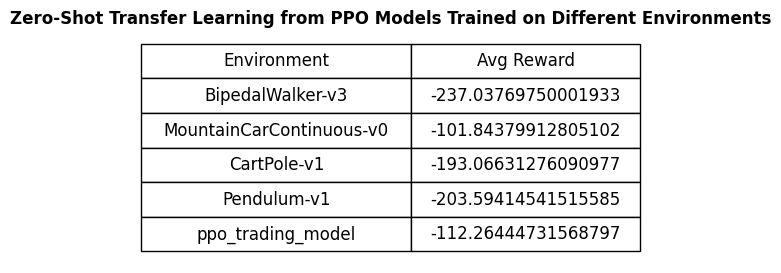

In [55]:
import matplotlib.pyplot as plt

# Example dictionary with environments and average rewards

# Convert dictionary into table format
env_names = list(results.keys())
rewards = list(results.values())

# Create a figure and axis
fig, ax = plt.subplots(figsize=(6, 3))

# Hide axes
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

# Create table data
table_data = list(zip(env_names, rewards))

# Create table
table = ax.table(cellText=table_data, colLabels=["Environment", "Avg Reward"],
                 cellLoc='center', loc='center')

# Style the table
table.auto_set_font_size(True)
table.set_fontsize(12)
table.auto_set_column_width([0, 1])  # Adjust column widths


# Add padding by increasing cell height and width
for key, cell in table.get_celld().items():
    cell.set_height(0.15)  # Increase row height for more padding
    cell.set_width(0.5)   # Increase column width for spacing
    cell.set_edgecolor('black')  # Ensure clear borders
# Set the title
ax.set_title("Zero-Shot Transfer Learning from PPO Models Trained on Different Environments", fontsize=12, fontweight="bold")

# Show the plot
plt.show()
